In [2]:
# Forces correct Python version (problem specific to Andrew G's Jupyter Notebooks)
import sys
!{sys.executable} -m pip install openai

# For most devs the following will be sufficient:
# ! pip install openai

In [ ]:
import openai

# Initialize the client
client = openai.OpenAI(api_key="")


In [8]:
#Prepare Dataset
import pandas as pd
df = pd.read_csv("MenoLearn_Dataset_JP.csv")
df

,Subquery,Response,Category,Subcategory
0,Can you recommend a medication for mood change...,"Venlafaxine, at 7.5 mg, is often recommended f...",Menopause Treatment,Mood Changes
1,What's the dosage for Gabapentin to treat meno...,Gabapentin is prescribed at 900 mg for menopau...,Menopause Treatment,Medication Dosage
2,Is there a treatment for loss of breast fullness?,"While loss of breast fullness is a concern, tr...",Menopause Treatment,Physical Changes
3,What are the side effects of Fezolinetant?,"Fezolinetant, a Neurokinin-3 receptor antagoni...",Medication Side Effects,Fezolinetant
4,Who should avoid HRT?,"Individuals with a history of cancer, liver di...",Treatment Options,Hormone Replacement Therapy
...,...,...,...,...
94,What is DRSP 3mg used for?,Effectiveness: nan Side effects: Uterine bleed...,DSRP,General Information
95,What is Estradiol and NETA 0.5 mg and1 mg used...,Effectiveness: nan Side effects: nan. Importan...,Estradiol and NETA,General Information
96,What is Estradiol and NETA 0.5 mg and 0.25 mg ...,Effectiveness: nan Side effects: nan. Importan...,Estradiol and NETA,General Information
97,What is Paroxetine 7.5 mg used for?,"Effectiveness: nan Side effects: Nausea, fatigue.",Paroxetine,General Information


In [10]:
! pwd

/Users/andrewgibson/MenoLearn/Fine-Tuning Chatbot 2025


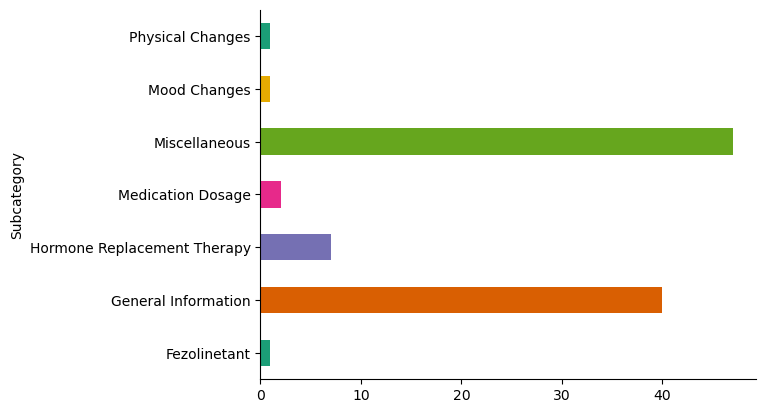

In [12]:
# @title Subcategory

from matplotlib import pyplot as plt
import seaborn as sns
#%config InlineBackend.figure_format ='retina'
df.groupby('Subcategory').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
#Format the dataset

def convert_to_gpt35_format(dataset):
    fine_tuning_data = []
    for _, row in dataset.iterrows():
        # Include both the direct response and the category information in the system's content
        system_content = f"Response: {row['Response']} Category: {row['Category']}; Subcategory: {row['Subcategory']}."
        fine_tuning_data.append({
            "messages": [
                {"role": "user", "content": row['Subquery']},  # Use 'Subquery' as the user's query
                {"role": "assistant", "content": system_content}  # Use 'assistant' role for the system's response
            ]
        })
    return fine_tuning_data

dataset = pd.read_csv("MenoLearn_Dataset_JP.csv")
converted_data = convert_to_gpt35_format(dataset)
converted_data[0]['messages']


[{'role': 'user',
  'content': 'Can you recommend a medication for mood changes during menopause?'},
 {'role': 'assistant',
  'content': "Response: Venlafaxine, at 7.5 mg, is often recommended for mood changes. It's an SSRI/SNRI, but watch out for dry mouth and decreased appetite. Category: Menopause Treatment; Subcategory: Mood Changes."}]

In [16]:
from sklearn.model_selection import train_test_split

# Assuming 'dataset' is your DataFrame loaded from the CSV file
train_df, val_df = train_test_split(
    dataset,
    test_size=0.2,
    random_state=42  # Ensures reproducibility
)

# Convert the split datasets into GPT-3.5 format
train_data = convert_to_gpt35_format(train_df)
val_data = convert_to_gpt35_format(val_df)


In [18]:
# Convert CSV dataset to JSON

import json

def save_to_jsonl(data, filename):
    with open(filename, "w") as f:
        for item in data:
            f.write(json.dumps(item) + "\n")

save_to_jsonl(train_data, "train.jsonl")
save_to_jsonl(val_data, "val.jsonl")

In [20]:
# Upload training file
with open("train.jsonl", "rb") as f:
    train_file = client.files.create(file=f, purpose="fine-tune")

# Upload validation file
with open("val.jsonl", "rb") as f:
    val_file = client.files.create(file=f, purpose="fine-tune")

print("Train file ID:", train_file.id)
print("Validation file ID:", val_file.id)

Train file ID: file-7DbErtuxCjHCUwebHpdk93
Validation file ID: file-T6RLRCYqukoBfY1Mqq9Q1i


In [22]:
# Start fine-tuning

fine_tune_response = client.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=val_file.id,
    model="gpt-3.5-turbo"
)

print("Fine-tune job ID:", fine_tune_response.id)

Fine-tune job ID: ftjob-FSLWlTI8kkW9o4JmNed6Sd5s


In [24]:
# Print job ID and status
job_id = fine_tune_response.id
status = client.fine_tuning.jobs.retrieve(job_id)
print(status)

FineTuningJob(id='ftjob-FSLWlTI8kkW9o4JmNed6Sd5s', created_at=1746471291, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=3), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-Ckr1jkijnZKzlFcpsWfNYibg', result_files=[], seed=1359975794, status='validating_files', trained_tokens=None, training_file='file-7DbErtuxCjHCUwebHpdk93', validation_file='file-T6RLRCYqukoBfY1Mqq9Q1i', estimated_finish=None, integrations=[], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=3)), type='supervised'), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False)


In [26]:
# Wait for the job to be finished (check status every few seconds)
import time

while status.status != "succeeded":
    print(f"Job status: {status.status}, waiting...")
    time.sleep(10)  # Wait for 10 seconds before checking again
    status = client.fine_tuning.jobs.retrieve(job_id)

Job status: validating_files, waiting...
Job status: validating_files, waiting...
Job status: validating_files, waiting...
Job status: validating_files, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...
Job status: running, waiting...


In [159]:
# Once the fine-tuning is completed, get the fine-tuned model

fine_tuned_model = status.fine_tuned_model
print(fine_tuned_model)

ft:gpt-3.5-turbo-0125:menolearn::BN42llXq


In [161]:
# Make a request to the fine-tuned model
# Note: "BadRequestError" means that fine-tuning is still queued and has not finished. Wait for longer...

response = client.chat.completions.create(
    model=fine_tuned_model,
    messages=[
        {"role": "user", "content": "What is your custom behavior?"}
    ]
)

print(response.choices[0].message.content)

Response: This is a default message. Category: General; Subcategory: Miscellaneous.
